In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install helpers

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


!cp /content/drive/MyDrive/CSE_455_Project/utils.py .
!cp /content/drive/MyDrive/CSE_455_Project/BirdDataSet.py .
!cp /content/drive/MyDrive/CSE_455_Project/Simple_DLA.py .
from utils import *
from BirdDataSet import BirdDataset

checkpoints = '/content/drive/MyDrive/CSE_455_Project/birds21wi/checkpoint/'
class_to_idx = {}
classes = sorted([str(i) for i in range(555)])
for i in range(len(classes)):
    class_to_idx[classes[i]] = str(i)

In [5]:
# import os
# if not os.path.exists('birds21wi'):
#     !mkdir birds21wi
#     os.chdir('birds21wi')
#     !wget https://pjreddie.com/media/files/birds/train.tar
#     !wget https://pjreddie.com/media/files/birds/test.tar
#     !wget https://pjreddie.com/media/files/birds/names.txt
#     !tar xf train.tar
#     !tar xf test.tar
#     !mkdir testing
#     !mv test testing
#     os.chdir('..')
import os
if not os.path.exists('birds21wi'):
    !mkdir birds21wi
    os.chdir('birds21wi')
    !wget https://pjreddie.com/media/files/birds/test.tar
    !wget https://pjreddie.com/media/files/birds/names.txt
    !tar xf test.tar
    !mkdir testing
    !mv test testing
    os.chdir('..')

--2021-03-14 22:30:07--  https://pjreddie.com/media/files/birds/test.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2057210880 (1.9G) [application/octet-stream]
Saving to: ‘test.tar’

test.tar            100%[===================>]   1.92G  41.9MB/s    in 46s     

2021-03-14 22:30:54 (42.6 MB/s) - ‘test.tar’ saved [2057210880/2057210880]

--2021-03-14 22:30:54--  https://pjreddie.com/media/files/birds/names.txt
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13755 (13K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>]  13.43K  --.-KB/s    in 0s      

2021-03-14 22:30:54 (368 MB/s) - ‘names.txt’ saved [13755/13755]



In [7]:
def get_bird_data(augmentation=0):
    transform_train = transforms.Compose([
        transforms.RandomCrop(128, padding=8, padding_mode='edge'), # Take 128x128 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
    ])
    trainset = BirdDataset("/content/drive/MyDrive/CSE_455_Project/training/*.h5", transform=transform_train)
    # trainset = torchvision.datasets.ImageFolder(root='birds21wi/train', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testset = torchvision.datasets.ImageFolder(root='birds21wi/testing', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    classes = open("birds21wi/names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

In [8]:
print(data['to_class'])
print(data['to_name'])
print(len(data['to_class']))

{0: 0, 1: 1, 2: 10, 3: 100, 4: 101, 5: 102, 6: 103, 7: 104, 8: 105, 9: 106, 10: 107, 11: 108, 12: 109, 13: 11, 14: 110, 15: 111, 16: 112, 17: 113, 18: 114, 19: 115, 20: 116, 21: 117, 22: 118, 23: 119, 24: 12, 25: 120, 26: 121, 27: 122, 28: 123, 29: 124, 30: 125, 31: 126, 32: 127, 33: 128, 34: 129, 35: 13, 36: 130, 37: 131, 38: 132, 39: 133, 40: 134, 41: 135, 42: 136, 43: 137, 44: 138, 45: 139, 46: 14, 47: 140, 48: 141, 49: 142, 50: 143, 51: 144, 52: 145, 53: 146, 54: 147, 55: 148, 56: 149, 57: 15, 58: 150, 59: 151, 60: 152, 61: 153, 62: 154, 63: 155, 64: 156, 65: 157, 66: 158, 67: 159, 68: 16, 69: 160, 70: 161, 71: 162, 72: 163, 73: 164, 74: 165, 75: 166, 76: 167, 77: 168, 78: 169, 79: 17, 80: 170, 81: 171, 82: 172, 83: 173, 84: 174, 85: 175, 86: 176, 87: 177, 88: 178, 89: 179, 90: 18, 91: 180, 92: 181, 93: 182, 94: 183, 95: 184, 96: 185, 97: 186, 98: 187, 99: 188, 100: 189, 101: 19, 102: 190, 103: 191, 104: 192, 105: 193, 106: 194, 107: 195, 108: 196, 109: 197, 110: 198, 111: 199, 112

torch.Size([128, 3, 128, 128])
torch.LongTensor
 
128


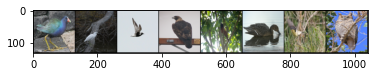

Labels:Greater Scaup (Breeding male), Warbling Vireo, Black Rosy-Finch, American Redstart (Female/juvenile), Mallard (Breeding male), Black Skimmer, Glaucous-winged Gull (Immature), Nashville Warbler
[295, 111, 338, 547, 47, 377, 123, 368]
[364, 199, 402, 92, 140, 438, 209, 43]
['Greater Scaup (Breeding male)', 'Warbling Vireo', 'Black Rosy-Finch', 'American Redstart (Female/juvenile)', 'Mallard (Breeding male)', 'Black Skimmer', 'Glaucous-winged Gull (Immature)', 'Nashville Warbler']


In [9]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
labels = labels.type(torch.LongTensor)
print(images.shape)
images = images[:8]
print(labels.type())
print(" ")
print(len(labels))

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))
print([labels[j].item() for j in range(8)])
print([data['to_class'][labels[j].item()] for j in range(8)])
print([data['to_name'][labels[j].item()] for j in range(8)])

In [10]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs = batch[0].to(device)
            labels = batch[1].type(torch.LongTensor)
            labels = batch[1].to(device)
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            running_correct += (labels==predicted).sum().item()
            sum_loss += loss.item()
            total += labels.size(0)
            # epoch_loss = running_loss/len(trainloader)
            # epoch_acc = 100/32*running_correct/len(trainloader)
            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f acc: %.3f' % (epoch, i + 1, sum_loss / print_every, 100.0 *running_correct/total))
                sum_loss = 0.0
                running_correct=0.0
                total = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

In [8]:
def accuracy(net, dataloader):
  net.to(device)
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

In [11]:
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
# input_size = resnet.fc.in_features
# output_size = resnet.fc.out_features
# print(input_size)
# print(output_size)

# last_fc = nn.Sequential(
#     nn.Linear(input_size, len(data['class_to_idx'])),nn.Softmax(dim=1))

# resnet.fc = last_fc
# losses = train(resnet, data['train'], epochs=20, lr=.01, decay=0.005, print_every=10, checkpoint_path=checkpoints)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [12]:
resnet.fc = nn.Sequential(
     nn.Linear(2048, 1024),
     nn.Linear(1024,555))

In [5]:
resnet.fc = nn.Sequential(
     nn.Linear(2048, 1024),
     nn.ReLU(),
     nn.Dropout(0.2),
     nn.Linear(1024,555),
     nn.LogSoftmax(dim=1))

In [ ]:
losses = train(resnet, data['train'], epochs=20, lr=.01, decay=0.0005, print_every=10, state=None, checkpoint_path=checkpoints)

[0,    10] loss: 6.326 acc: 0.234
[0,    20] loss: 6.297 acc: 0.391
[0,    30] loss: 6.259 acc: 1.172
[0,    40] loss: 6.206 acc: 1.484
[0,    50] loss: 6.144 acc: 2.422
[0,    60] loss: 6.080 acc: 2.422
[0,    70] loss: 5.938 acc: 3.516
[0,    80] loss: 5.847 acc: 3.047
[0,    90] loss: 5.629 acc: 6.016
[0,   100] loss: 5.483 acc: 6.719
[0,   110] loss: 5.255 acc: 7.891
[0,   120] loss: 5.106 acc: 7.031
[0,   130] loss: 4.961 acc: 8.750
[0,   140] loss: 4.751 acc: 11.172
[0,   150] loss: 4.611 acc: 10.547
[0,   160] loss: 4.419 acc: 13.594
[0,   170] loss: 4.307 acc: 12.109
[0,   180] loss: 4.179 acc: 12.734
[0,   190] loss: 4.070 acc: 14.531
[0,   200] loss: 3.982 acc: 14.922
[0,   210] loss: 3.827 acc: 17.031
[0,   220] loss: 3.792 acc: 18.203
[0,   230] loss: 3.722 acc: 17.812
[0,   240] loss: 3.713 acc: 17.422
[0,   250] loss: 3.419 acc: 23.047
[0,   260] loss: 3.438 acc: 20.781
[0,   270] loss: 3.422 acc: 21.562
[0,   280] loss: 3.244 acc: 24.609
[0,   290] loss: 3.231 acc: 24.92

In [22]:
losses = train(resnet, data['train'], epochs=20, lr=.01, decay=0.0005, print_every=10, state=None, checkpoint_path=checkpoints)

[0,    10] loss: 6.331 acc: 0.156
[0,    20] loss: 6.263 acc: 0.859
[0,    30] loss: 6.164 acc: 1.484
[0,    40] loss: 6.063 acc: 3.281
[0,    50] loss: 5.866 acc: 3.516
[0,    60] loss: 5.612 acc: 5.781
[0,    70] loss: 5.319 acc: 7.656
[0,    80] loss: 5.140 acc: 8.125
[0,    90] loss: 4.828 acc: 10.469
[0,   100] loss: 4.586 acc: 10.547
[0,   110] loss: 4.380 acc: 13.438
[0,   120] loss: 4.158 acc: 13.828
[0,   130] loss: 4.086 acc: 14.766
[0,   140] loss: 3.881 acc: 17.656
[0,   150] loss: 3.740 acc: 19.531
[0,   160] loss: 3.570 acc: 22.109
[0,   170] loss: 3.465 acc: 24.062
[0,   180] loss: 3.362 acc: 24.766
[0,   190] loss: 3.385 acc: 23.750
[0,   200] loss: 3.283 acc: 26.406
[0,   210] loss: 3.251 acc: 24.844
[0,   220] loss: 3.046 acc: 28.203
[0,   230] loss: 3.009 acc: 29.297
[0,   240] loss: 2.991 acc: 28.516
[0,   250] loss: 2.816 acc: 31.328
[0,   260] loss: 2.888 acc: 29.844
[0,   270] loss: 2.812 acc: 32.812
[0,   280] loss: 2.855 acc: 30.547
[0,   290] loss: 2.667 acc: 

In [28]:
losses = train(resnet, data['train'], epochs=30, lr=.01, decay=0.0005, print_every=10, state=torch.load(checkpoints+'checkpoint50Drop-20.pkl'), checkpoint_path=checkpoints)

[20,    10] loss: 0.359 acc: 88.438
[20,    20] loss: 0.388 acc: 88.594
[20,    30] loss: 0.413 acc: 88.125
[20,    40] loss: 0.394 acc: 87.891
[20,    50] loss: 0.349 acc: 89.297
[20,    60] loss: 0.385 acc: 88.203
[20,    70] loss: 0.384 acc: 89.844
[20,    80] loss: 0.376 acc: 89.062
[20,    90] loss: 0.348 acc: 89.297
[20,   100] loss: 0.353 acc: 88.672
[20,   110] loss: 0.386 acc: 88.750
[20,   120] loss: 0.393 acc: 88.281
[20,   130] loss: 0.413 acc: 87.344
[20,   140] loss: 0.409 acc: 88.750
[20,   150] loss: 0.416 acc: 86.406
[20,   160] loss: 0.428 acc: 87.734
[20,   170] loss: 0.477 acc: 85.547
[20,   180] loss: 0.410 acc: 87.734
[20,   190] loss: 0.439 acc: 86.797
[20,   200] loss: 0.449 acc: 86.484
[20,   210] loss: 0.412 acc: 87.812
[20,   220] loss: 0.408 acc: 87.422
[20,   230] loss: 0.366 acc: 89.297
[20,   240] loss: 0.429 acc: 88.125
[20,   250] loss: 0.385 acc: 88.359
[20,   260] loss: 0.423 acc: 87.422
[20,   270] loss: 0.430 acc: 86.953
[20,   280] loss: 0.487 acc:

In [7]:
checkpoint = torch.load(checkpoints+'checkpoint50Drop-30.pkl')
losses = checkpoint['losses']
# resnet.load_state_dict(checkpoint['net'])
plt.plot(smooth(losses,50))
plt.ylabel('losses')

NameError: ignored

In [11]:
losses = train(resnet, data['train'], epochs=20, lr=.01, decay=0.0005, print_every=10, state=None, checkpoint_path=checkpoints)

[0,    10] loss: 6.342 acc: 0.078
[0,    20] loss: 6.271 acc: 0.938
[0,    30] loss: 6.172 acc: 1.562
[0,    40] loss: 6.032 acc: 3.203
[0,    50] loss: 5.835 acc: 5.547
[0,    60] loss: 5.541 acc: 6.094
[0,    70] loss: 5.237 acc: 9.062
[0,    80] loss: 5.008 acc: 8.359
[0,    90] loss: 4.699 acc: 11.562
[0,   100] loss: 4.352 acc: 14.844
[0,   110] loss: 4.220 acc: 13.906
[0,   120] loss: 3.951 acc: 16.797
[0,   130] loss: 3.806 acc: 20.781
[0,   140] loss: 3.682 acc: 21.484
[0,   150] loss: 3.505 acc: 23.438
[0,   160] loss: 3.459 acc: 23.984
[0,   170] loss: 3.236 acc: 24.844
[0,   180] loss: 3.127 acc: 30.234
[0,   190] loss: 3.075 acc: 29.141
[0,   200] loss: 2.961 acc: 27.734
[0,   210] loss: 3.012 acc: 27.734
[0,   220] loss: 2.854 acc: 31.328
[0,   230] loss: 2.845 acc: 31.719
[0,   240] loss: 2.656 acc: 33.984
[0,   250] loss: 2.709 acc: 34.375
[0,   260] loss: 2.700 acc: 32.578
[0,   270] loss: 2.641 acc: 34.766
[0,   280] loss: 2.485 acc: 38.203
[0,   290] loss: 2.509 acc: 

In [18]:
losses = train(resnet, data['train'], epochs=30, lr=.01, decay=0.0005, print_every=10, state = torch.load(checkpoints+'checkpointDrop-20.pkl'), checkpoint_path=checkpoints)

[20,    10] loss: 0.329 acc: 89.922
[20,    20] loss: 0.354 acc: 88.672
[20,    30] loss: 0.335 acc: 89.531
[20,    40] loss: 0.302 acc: 92.031
[20,    50] loss: 0.302 acc: 90.000
[20,    60] loss: 0.251 acc: 92.422
[20,    70] loss: 0.333 acc: 88.984
[20,    80] loss: 0.292 acc: 91.484
[20,    90] loss: 0.332 acc: 90.703
[20,   100] loss: 0.295 acc: 91.016
[20,   110] loss: 0.286 acc: 91.406
[20,   120] loss: 0.303 acc: 91.797
[20,   130] loss: 0.294 acc: 91.328
[20,   140] loss: 0.299 acc: 91.250
[20,   150] loss: 0.290 acc: 91.250
[20,   160] loss: 0.317 acc: 90.391
[20,   170] loss: 0.319 acc: 90.234
[20,   180] loss: 0.382 acc: 88.047
[20,   190] loss: 0.326 acc: 89.766
[20,   200] loss: 0.316 acc: 90.859
[20,   210] loss: 0.353 acc: 88.594
[20,   220] loss: 0.328 acc: 90.156
[20,   230] loss: 0.366 acc: 89.141
[20,   240] loss: 0.346 acc: 90.469
[20,   250] loss: 0.377 acc: 88.750
[20,   260] loss: 0.406 acc: 86.719
[20,   270] loss: 0.356 acc: 90.000
[20,   280] loss: 0.405 acc:

KeyboardInterrupt: ignored

In [20]:
losses = train(resnet, data['train'], start_epoch=10, epochs=20,lr=.001,decay=0.0005, print_every=10, checkpoint_path=checkpoints)

[10,    10] loss: 0.637 acc: 81.250
[10,    20] loss: 0.592 acc: 81.797
[10,    30] loss: 0.547 acc: 84.062
[10,    40] loss: 0.542 acc: 84.375
[10,    50] loss: 0.466 acc: 87.969
[10,    60] loss: 0.514 acc: 85.625
[10,    70] loss: 0.456 acc: 87.500
[10,    80] loss: 0.423 acc: 87.891
[10,    90] loss: 0.443 acc: 87.500
[10,   100] loss: 0.461 acc: 86.875
[10,   110] loss: 0.436 acc: 87.031
[10,   120] loss: 0.413 acc: 88.281
[10,   130] loss: 0.478 acc: 86.875
[10,   140] loss: 0.406 acc: 88.672
[10,   150] loss: 0.397 acc: 89.766
[10,   160] loss: 0.436 acc: 88.203
[10,   170] loss: 0.407 acc: 88.281
[10,   180] loss: 0.410 acc: 89.453
[10,   190] loss: 0.412 acc: 89.375
[10,   200] loss: 0.381 acc: 89.297
[10,   210] loss: 0.371 acc: 91.328
[10,   220] loss: 0.416 acc: 88.672
[10,   230] loss: 0.387 acc: 89.297
[10,   240] loss: 0.418 acc: 89.688
[10,   250] loss: 0.394 acc: 88.750
[10,   260] loss: 0.395 acc: 89.453
[10,   270] loss: 0.420 acc: 88.906
[10,   280] loss: 0.374 acc:

In [25]:
losses = train(resnet, data['train'], start_epoch=20, epochs=30,lr=.001,decay=0.005, print_every=10, checkpoint_path=checkpoints)

[20,    10] loss: 0.240 acc: 96.406
[20,    20] loss: 0.229 acc: 97.266
[20,    30] loss: 0.239 acc: 96.406
[20,    40] loss: 0.238 acc: 95.938
[20,    50] loss: 0.269 acc: 96.172
[20,    60] loss: 0.237 acc: 96.406
[20,    70] loss: 0.237 acc: 96.562
[20,    80] loss: 0.239 acc: 96.641
[20,    90] loss: 0.252 acc: 96.250
[20,   100] loss: 0.257 acc: 96.484
[20,   110] loss: 0.247 acc: 96.250
[20,   120] loss: 0.260 acc: 95.703
[20,   130] loss: 0.231 acc: 96.172
[20,   140] loss: 0.224 acc: 96.562
[20,   150] loss: 0.236 acc: 96.250
[20,   160] loss: 0.253 acc: 96.016
[20,   170] loss: 0.245 acc: 96.094
[20,   180] loss: 0.237 acc: 96.094
[20,   190] loss: 0.259 acc: 95.391
[20,   200] loss: 0.252 acc: 95.938
[20,   210] loss: 0.250 acc: 96.250
[20,   220] loss: 0.246 acc: 96.250
[20,   230] loss: 0.256 acc: 95.625
[20,   240] loss: 0.257 acc: 96.094
[20,   250] loss: 0.266 acc: 95.391
[20,   260] loss: 0.263 acc: 96.094


KeyboardInterrupt: ignored

In [52]:
checkpoint = torch.load(checkpoints+'checkpoint-30.pkl')
ck_loss = checkpoint['losses']
resnet.load_state_dict(checkpoint['net'])

<All keys matched successfully>

In [24]:
losses = train(resnet, data['train'], epochs=20, lr=.001, decay = 0.0005, print_every=10, state=torch.load(checkpoints+'checkpoint-35.pkl'),checkpoint_path=checkpoints+'checkpoint-45.pkl')

[5,    10] loss: 0.102 acc: 98.281
[5,    20] loss: 0.099 acc: 98.594
[5,    30] loss: 0.118 acc: 98.047
[5,    40] loss: 0.114 acc: 97.734
[5,    50] loss: 0.110 acc: 98.438
[5,    60] loss: 0.103 acc: 98.125
[5,    70] loss: 0.122 acc: 97.500
[5,    80] loss: 0.106 acc: 98.516
[5,    90] loss: 0.105 acc: 98.203
[5,   100] loss: 0.127 acc: 98.047
[5,   110] loss: 0.109 acc: 98.047
[5,   120] loss: 0.125 acc: 97.344
[5,   130] loss: 0.117 acc: 98.203
[5,   140] loss: 0.101 acc: 98.594
[5,   150] loss: 0.110 acc: 97.891
[5,   160] loss: 0.126 acc: 97.266
[5,   170] loss: 0.115 acc: 98.516
[5,   180] loss: 0.114 acc: 97.812
[5,   190] loss: 0.120 acc: 97.812
[5,   200] loss: 0.117 acc: 97.969
[5,   210] loss: 0.116 acc: 97.891
[5,   220] loss: 0.119 acc: 98.125
[5,   230] loss: 0.105 acc: 98.750
[5,   240] loss: 0.124 acc: 97.109
[5,   250] loss: 0.123 acc: 97.656


KeyboardInterrupt: ignored

In [ ]:
# !cp /content/SimpleDLA.py
# from SimpleDLA import *

# net = SimpleDLA()
# net = net.to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True
# overfitted_loss = train(net, data['train'], epochs=5, lr=.01, print_every=10, checkpoint_path=checkpoints)

Text(0, 0.5, 'losses')

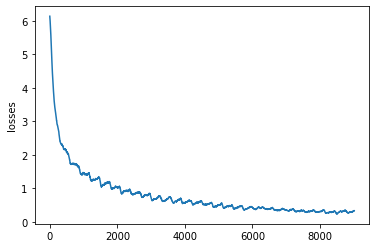

In [10]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

plt.plot(smooth(losses,50))
plt.ylabel('losses')

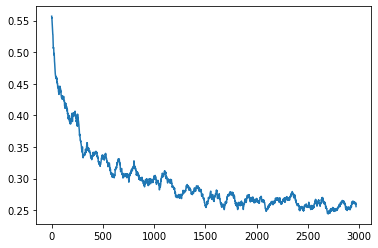

In [21]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')
plt.plot(smooth(losses,50))

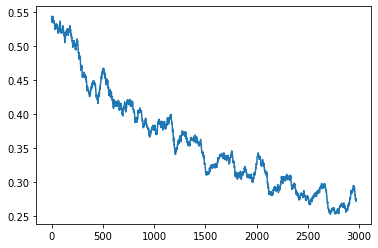

In [36]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')
plt.plot(smooth(losses,50))

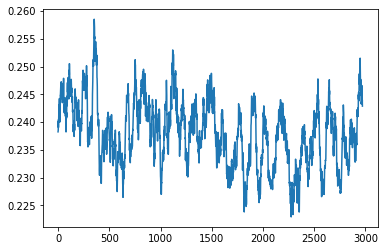

In [53]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')
plt.plot(smooth(ck_loss,50))

In [21]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], predicted.item()))
    out.close()

In [25]:
predict(resnet, data['test'], checkpoints + "preds.csv")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [56]:
print("Testing  accuracy: %f" % accuracy(resnet, data['train']))

Testing  accuracy: 0.973186
